## Importing packages

In [2]:
!pip install contractions

     |████████████████████████████████| 106 kB 5.0 MB/s 
     |████████████████████████████████| 284 kB 25.8 MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.figure(figsize=(11, 9))
import re
import contractions
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from gensim.models import KeyedVectors
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


<Figure size 792x648 with 0 Axes>

## Loading the data-set

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Kaggle Competition/Toxic Comment Classification/train.csv')
df['toxic_or_not'] = df.iloc[:, 2] + df.iloc[:, 3] + df.iloc[:, 4] + df.iloc[:, 5] + df.iloc[:, 6] + df.iloc[:, 7]
df.head()
df.iloc[df['toxic_or_not'] != 0, -1] = 1


## Cleaning & Preprocessing the text data

In [ ]:
# Removing all non-alphabetical characters
cleaned_text = []
for i in range(df.shape[0]):
  text = df.comment_text.values[i].lower()
  text = re.sub(r'[^a-zA-Z\']', ' ', text)
  text = re.sub(r'^\s+|\s+$', '', text)
  cleaned_text.append(text)

# Replacing contraction terms
decontracted_text = []
for text in cleaned_text:
  decontracted_words = []
  for word in text.split():
    decontracted_words.append(contractions.fix(word).lower())
  decontracted_text.append(re.sub(r'\'', "", " ".join(decontracted_words)))


## NOTE: This part is commented out because Lemmatization 
##       did not show any significant improvement in model performance
'''
# Lemmatization
wnl = WordNetLemmatizer()
lemmatized_text = []
for text in decontracted_text:
  lt = ""
  for word in text.split():
    w1 = wnl.lemmatize(word, pos='n') # for nouns
    w2 = wnl.lemmatize(w1, pos='v') # for verbs
    w3 = wnl.lemmatize(w2, pos='a') # for adjectives
    w4 = wnl.lemmatize(w3, pos='r') # for adverbs
    w5 = wnl.lemmatize(w4, pos='s') # for satellite adjectives
    lt += " " + w5
  lemmatized_text.append(lt.strip())
'''

# Removing stop words and words less than 3 characters long
preprocessed_text = []
tokenized_text = [word_tokenize(text) for text in decontracted_text]

for text in tokenized_text:
  filtered_words = [word for word in text if word not in set(stopwords.words('english')) and len(word) > 2]
  preprocessed_text.append(filtered_words)

preprocessed_comments = [" ".join(comment).strip() for comment in preprocessed_text]

df['preprocessed_comments'] = preprocessed_comments

X = df.drop(labels=['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'toxic_or_not'], axis=1)
print(X.head())
y = df.toxic_or_not

                               preprocessed_comments
0  explanation edits made username hardcore metal...
1  daww matches background colour seemingly stuck...
2  hey man really trying edit war guy constantly ...
3  make real suggestions improvement wondered sec...
4                      sir hero chance remember page


## Loading glove vectors

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = '/content/drive/MyDrive/Kaggle Competition/Toxic Comment Classification/glove.6B.300d.txt'
word2vec_output_file = '/content/drive/MyDrive/Kaggle Competition/Toxic Comment Classification/glove.6B.300d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 300)

In [ ]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = '/content/drive/MyDrive/Kaggle Competition/Toxic Comment Classification/glove.6B.300d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)
# calculate: (king - man) + woman = ?
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

[('queen', 0.6713277101516724)]


## Converting text into 300 dimensional vectors

In [ ]:
vectorized_text = np.empty((len(X.preprocessed_comments), 300))
for sent in tqdm(X.preprocessed_comments.values):
  sent_vec = np.zeros(300)
  #numw = 0
  for w in sent.split():
    try:
      sent_vec = np.add(sent_vec, model[w])
      #numw+=1
    except:
      pass
    vectorized_text[list(X.preprocessed_comments.values).index(sent)] = sent_vec / (np.sqrt(sent_vec.dot(sent_vec)) + 0.0001)

vectorized_text.shape

100%|██████████| 159571/159571 [1:00:27<00:00, 43.99it/s]


(159571, 300)

In [ ]:
vectorized_df = np.hstack((vectorized_text, y.values.reshape(-1, 1)))

In [ ]:
vdf = pd.DataFrame(vectorized_df, columns=list(range(301)))

## Upsampling the minority class data

In [ ]:
from sklearn.utils import resample
n_samp = int(len(vectorized_df[:, -1]) - vectorized_df[:, -1].sum())
upsampled = resample(vdf.iloc[(vdf.iloc[:, -1] == 1).values, :], replace=True, n_samples=n_samp, random_state=24)
upsampled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300
124851,0.013226,0.003143,-0.005393,0.027449,0.018646,0.004611,0.018882,0.013578,0.018952,-0.492189,0.011014,-0.000072,-0.031077,0.030243,0.036437,0.000997,-0.000043,0.008995,0.043368,0.016066,0.027829,0.086046,0.053625,-0.005319,-0.063793,0.013737,0.006627,-0.017166,0.004168,0.030664,0.007852,0.067971,-0.065003,-0.039423,-0.204554,0.032035,-0.022312,-0.013909,-0.014183,0.001230,...,-0.034494,-0.008899,0.029698,-0.018538,-0.011372,0.002005,-0.019351,-0.018085,0.027192,0.063007,-0.027845,0.040313,0.012256,0.012346,0.024946,-0.556295,-0.003787,0.175801,0.005350,0.011148,-0.010680,0.023869,0.018204,0.026873,0.005007,0.048168,0.001568,-0.031969,-0.015329,-0.003700,-0.044368,0.025972,-0.001186,0.043639,-0.071344,-0.021027,-0.025135,0.013790,-0.002424,1.0
8559,-0.032784,0.035053,0.000036,0.020897,-0.051423,0.040759,-0.082909,0.007083,0.059558,-0.178541,-0.005708,-0.010327,0.045677,0.003848,-0.000642,-0.094765,-0.039302,0.002227,-0.075349,0.011176,0.050171,0.003183,0.125286,-0.058030,-0.076259,0.013500,0.070266,0.041686,-0.067431,0.001033,-0.062157,-0.049455,-0.014240,-0.125621,0.023869,-0.039585,-0.093023,-0.037638,0.058627,0.071307,...,-0.120553,-0.055425,0.023101,0.009393,-0.010893,-0.081305,0.013477,-0.022299,-0.023783,0.088554,0.110200,0.012939,0.068356,-0.004897,0.003482,-0.201867,0.052680,0.131295,-0.017383,0.072288,0.028398,0.046048,0.087659,0.097895,-0.088502,0.082697,-0.078755,0.018235,-0.028229,0.001532,-0.107014,0.059848,-0.107042,0.020089,-0.096852,-0.039655,0.021232,0.017177,-0.006070,1.0
143009,-0.026633,0.004367,-0.009340,-0.031012,0.008634,0.017152,-0.026679,0.003534,0.022239,-0.447504,0.034842,0.002403,-0.008972,0.016990,-0.015384,0.002291,-0.029777,0.008379,0.007346,0.022789,0.038168,0.072371,0.047138,0.002377,-0.061430,-0.013888,0.007261,-0.009918,0.027239,-0.004751,-0.019632,0.049304,-0.038452,-0.012767,-0.298597,0.010659,-0.008578,-0.002919,-0.016008,0.003721,...,-0.026292,0.034913,0.010204,-0.046320,0.007522,-0.036044,-0.012160,0.020598,0.029229,0.004346,-0.029506,0.049267,0.009785,0.019487,0.006593,-0.565747,0.003501,0.124070,-0.002456,-0.034994,-0.014832,0.011282,0.015499,-0.000331,0.015583,0.028351,0.014481,-0.002427,0.014072,0.016201,-0.029264,-0.014488,0.028273,0.034640,0.005818,0.008914,-0.026558,-0.037363,0.018705,1.0
83320,-0.004703,-0.038201,-0.020483,0.003955,-0.011984,0.026109,-0.011456,0.055308,-0.072683,-0.092727,0.086541,-0.031878,-0.032054,0.048497,0.024934,-0.033702,0.012774,-0.031498,0.097818,0.138503,-0.008053,0.125330,0.049497,-0.030821,-0.000782,-0.011061,0.001390,-0.095432,0.059509,-0.051617,-0.019855,0.108390,-0.086955,-0.036967,-0.067188,0.025703,-0.091836,0.003740,-0.091163,-0.000914,...,-0.070218,0.000316,0.044396,0.031252,0.054368,-0.032394,-0.075162,-0.011473,0.040148,-0.035182,0.001473,0.026058,0.085239,0.014167,-0.010716,-0.146325,-0.112007,0.014359,0.004742,0.008555,-0.079345,-0.051565,0.102088,-0.071194,0.064229,-0.027155,-0.046550,0.026011,-0.017664,-0.075428,0.046279,-0.047089,0.058712,0.005898,-0.098676,0.024111,0.102588,-0.013844,0.039565,1.0
33496,-0.071551,0.011769,-0.055764,-0.055451,0.013052,0.075812,-0.020107,-0.008570,0.001478,-0.283548,0.029276,-0.019418,-0.008413,0.011002,-0.020231,-0.037356,-0.047128,-0.015674,0.019674,0.078269,0.078782,0.137828,0.091801,0.029659,-0.043130,-0.003439,0.042618,-0.066460,0.039002,-0.013049,-0.025526,0.019613,-0.071952,-0.032028,-0.276918,0.076371,-0.053147,0.006046,0.002266,0.013808,...,-0.030755,0.041958,-0.027127,-0.039468,0.043295,-0.023298,-0.034445,-0.002127,0.092524,0.009668,-0.006475,0.064102,-0.026144,0.008595,0.040082,-0.450575,-0.028341,-0.013673,-0.043069,-0.040984,0.064310,-0.009798,0.010033,-0.000295,0.017463,0.015245,0.034445,-0.004323,-0.027829,-0.006149

In [ ]:
vdf = pd.concat([vdf, upsampled])
y = vdf.iloc[:, -1].values
X = vdf.iloc[:, :-1].values

In [ ]:
X.shape

(302917, 300)

In [ ]:
vdf.to_csv("/content/drive/MyDrive/Kaggle Competition/Toxic Comment Classification/final_vectorized_df_v3.csv", index=False)

In [ ]:
vdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300
0,-0.027819,-0.025097,0.016586,-0.020104,0.022592,-0.059228,0.004150,-0.012914,0.049142,-0.315883,-0.032242,0.019668,0.035890,-0.000023,0.048807,0.039578,-0.039247,0.043532,0.005504,-0.001936,-0.003266,0.059542,-0.001479,0.056500,-0.076261,-0.023908,-0.004028,0.063701,0.009539,-0.017370,-0.002115,-0.022223,-0.013678,0.064751,-0.202191,-0.036013,-0.025197,-0.011190,0.031519,0.073919,...,-0.000913,0.012888,-0.023898,-0.057215,-0.007245,-0.033332,0.076274,0.000099,0.008285,0.009558,-0.028828,0.040130,-0.100203,-0.014418,0.018199,-0.467499,-0.029749,0.128019,0.038582,-0.023534,0.001510,-0.086482,0.106401,-0.034978,0.019755,-0.026454,0.005563,-0.046814,0.031830,-0.008078,-0.074876,-0.034577,0.039661,0.044486,0.028640,0.014762,-0.043275,0.022245,0.079330,0.0
1,0.003658,0.030292,0.044201,0.015616,-0.025994,-0.022089,-0.027877,0.005170,0.080933,-0.379207,0.041585,0.044961,0.042747,0.002481,0.010122,-0.021659,0.011691,-0.014208,-0.010809,-0.067935,-0.015015,0.012737,-0.035356,0.016193,-0.018556,-0.014138,0.012336,0.029981,-0.040247,0.017729,0.022977,0.020243,-0.083738,0.055488,-0.291570,0.059373,0.026724,-0.001679,-0.046711,0.053502,...,0.006003,0.070821,-0.001347,-0.040245,-0.048724,0.009665,-0.062071,0.012574,-0.000425,0.025678,0.003306,-0.025590,-0.056002,0.034948,0.056377,-0.357104,-0.038377,0.098845,0.025903,-0.027757,0.008010,-0.015638,0.039098,0.059213,0.016151,-0.038535,0.004773,-0.011630,0.020077,0.001003,0.043182,-0.090644,-0.021627,0.044607,0.094748,0.021491,-0.008086,0.013397,-0.007012,0.0
2,-0.068402,-0.014055,0.004116,0.011997,0.006012,0.030367,-0.042237,-0.005672,0.054542,-0.414327,0.025655,0.001717,0.035715,0.021850,-0.023369,-0.028614,-0.005591,-0.033176,0.011961,0.013021,0.031250,0.132241,0.048353,0.031545,-0.056772,-0.049214,0.032867,0.012334,0.056128,0.028812,-0.062775,0.008095,-0.055607,0.019384,-0.229250,0.019337,-0.017867,-0.039173,-0.016380,-0.027603,...,-0.028762,-0.051410,0.013378,-0.002802,0.035154,-0.019316,0.006006,-0.007902,0.022511,-0.023300,0.002603,0.045759,0.008722,0.012989,0.040783,-0.483663,0.033180,0.148181,-0.032825,0.002921,-0.009938,0.018321,0.010478,0.065902,0.004569,0.031532,0.022979,-0.058782,-0.016875,0.032227,-0.035251,-0.022598,-0.012837,0.006447,-0.065600,-0.011346,-0.001462,-0.000895,0.036339,0.0
3,-0.052891,0.010332,-0.014360,-0.011176,-0.018650,0.006462,-0.017454,0.023015,0.003779,-0.452816,0.000996,0.041322,0.018896,0.039775,0.034204,-0.037212,-0.017184,0.004700,0.015089,-0.030674,0.001059,0.079253,0.013953,0.083211,-0.092904,0.012636,-0.012668,-0.010227,0.045538,-0.005429,0.009401,0.063544,-0.045084,0.009238,-0.256927,0.023886,0.010064,-0.019818,-0.039677,0.001845,...,-0.020084,-0.006162,-0.011139,-0.006311,-0.041134,-0.010668,0.005841,0.041330,0.001612,0.024574,-0.010231,0.045724,0.006784,0.008487,0.039887,-0.499015,0.023221,0.168110,0.019414,-0.021710,-0.007251,0.010424,0.021192,0.010794,0.012619,0.005633,-0.021994,-0.024732,0.010253,0.005150,-0.029167,-0.004759,-0.001911,0.021013,-0.006749,-0.064636,-0.064399,0.015458,0.003308,0.0
4,-0.012218,-0.013789,0.061857,-0.095299,0.048979,0.030729,-0.032299,-0.050947,-0.023149,-0.177743,0.047711,-0.023988,0.009553,-0.047121,-0.046293,0.044695,0.051264,-0.043966,0.040019,0.022214,0.014216,0.098731,0.090522,0.024059,-0.018332,-0.041072,0.024898,-0.012229,0.121006,-0.082352,-0.033106,-0.013403,-0.017137,-0.040260,-0.288930,-0.041369,-0.001611,0.019375,0.016246,-0.016887,...,-0.005525,0.084830,0.020833,-0.042022,0.005766,-0.011492,-0.049951,0.088124,0.022905,0.017484,-0.050194,0.100586,-0.050567,-0.073111,0.054939,-0.345947,-0.075534,0.135312,0.007280,-0.012892,-0.003919,0.060827,-0.039329,0.043097,0.016395,-0.025886,0.006912,-0.052462,0.012577,0.024402,0.014771,-0.005245,-0

## Splitting the data into train and test sets

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24, stratify=y)

## Training the ML model

In [ ]:
X_train.shape

(242333, 300)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss


rfc = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=100, class_weight='balanced')
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)


## Evaluating model performance

In [ ]:
from sklearn.metrics import accuracy_score

print(classification_report(y_test, y_pred))
print(log_loss(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     28669
         1.0       0.98      1.00      0.99     31915

    accuracy                           0.99     60584
   macro avg       0.99      0.99      0.99     60584
weighted avg       0.99      0.99      0.99     60584

0.36202006402283843
0.9895186848012677


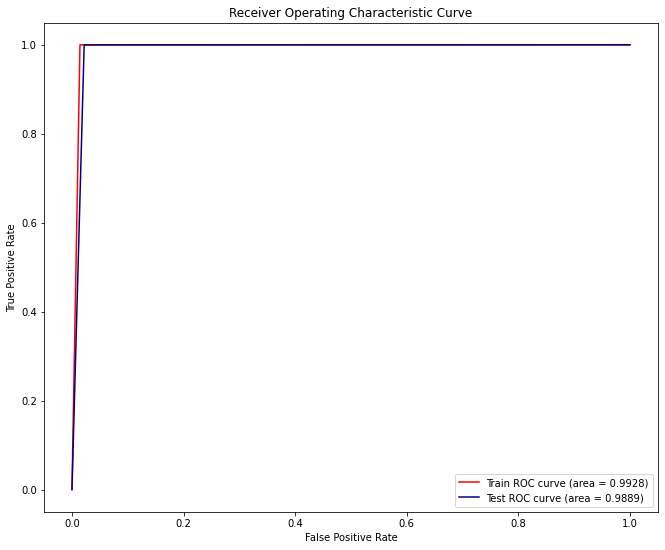

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(11, 9))
fpr_tr, tpr_tr, ths_tr = roc_curve(y_train, rfc.predict(X_train))
auc_tr = auc(fpr_tr, tpr_tr)
#fpr_cv, tpr_cv, ths_cv = roc_curve(y_cv, y_cv_pred)
#auc_cv = auc(fpr_cv, tpr_cv)
fpr_te, tpr_te, ths_te = roc_curve(y_test, rfc.predict(X_test))
auc_te = auc(fpr_te, tpr_te)
plt.plot(fpr_tr, tpr_tr, color='red', label='Train ROC curve (area = %0.4f)' % auc_tr)
#plt.plot(fpr_tr, tpr_tr, color='orange', label='ROC curve (area = %0.2f)' % au c_cv)
plt.plot(fpr_te, tpr_te, color='navy',label='Test ROC curve (area = %0.4f)' % auc_te)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

Train confusion_matrix


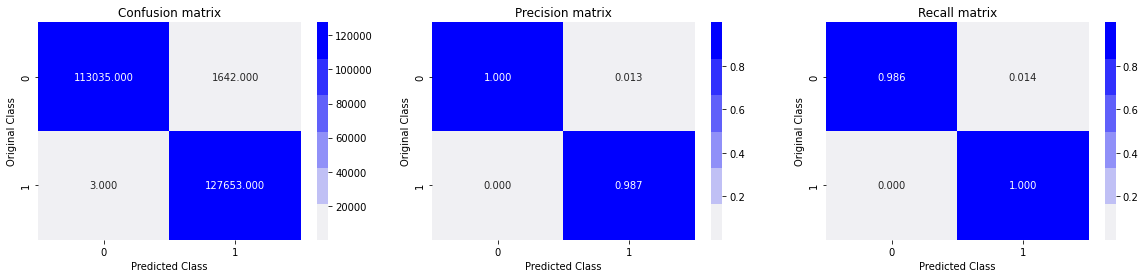


Test confusion_matrix


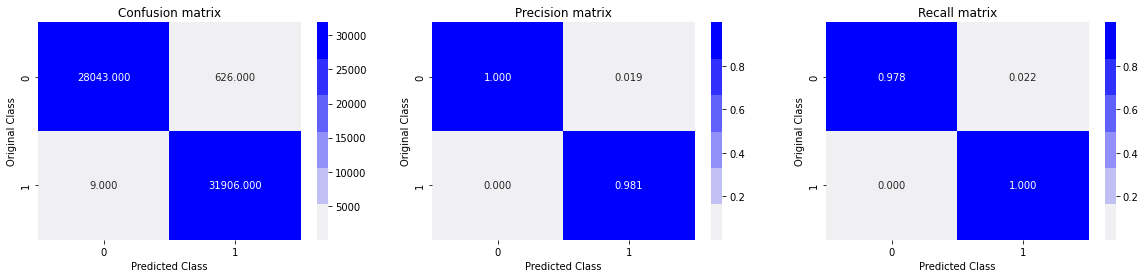

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_y, predict_y):
  C = confusion_matrix(test_y, predict_y)
  A =(((C.T)/(C.sum(axis=1))).T)
  B =(C/C.sum(axis=0))
  plt.figure(figsize=(20,4))
  labels = [0,1]
  # representing A in heatmap format
  cmap=sns.light_palette("blue")
  plt.subplot(1, 3, 1)
  sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title("Confusion matrix")

  plt.subplot(1, 3, 2)
  sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title("Precision matrix")
  
  plt.subplot(1, 3, 3)
  # representing B in heatmap format
  sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title("Recall matrix")
  plt.show()


print('Train confusion_matrix')
plot_confusion_matrix(y_train, rfc.predict(X_train))
print('\nTest confusion_matrix')
plot_confusion_matrix(y_test, rfc.predict(X_test))

## Saving the trained model as a pickle file

In [4]:
import pickle

In [ ]:
with open("/content/drive/MyDrive/Kaggle Competition/Toxic Comment Classification/rfc_model.pkl", "wb") as file:
  pickle.dump(rfc, file)

## Data Pre-processing pipeline for making predictions

In [7]:
kaggle_test = pd.read_csv("/content/drive/MyDrive/Kaggle Competition/Toxic Comment Classification/kaggle_test.csv")
kaggle_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [8]:
kaggle_test_list = kaggle_test['comment_text'].values.tolist()

In [10]:
def clean(comments):
  # Removing all non-alphabetical characters
  cleaned_comments = []
  for text in comments:
    #print(text)
    #print(type(text))
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    text = re.sub(r'^\s+|\s+$', '', text)
    cleaned_comments.append(text)
  #print(cleaned_comments)
  return cleaned_comments


def decontract(cleaned_comments):
  #Replacing contraction terms
  decontracted_comments = []
  for comment in cleaned_comments:
    decontracted_words = []
    for word in comment.split():
      decontracted_words.append(contractions.fix(word).lower())
    decontracted_comments.append(re.sub(r'\'', "", " ".join(decontracted_words).strip()))
  #print(decontracted_comments)
  return decontracted_comments


def remove_stopwords(decontracted_comments):
  preprocessed_comments = []
  for comment in decontracted_comments:
    comment_words = comment.split()
    filtered_words = [word for word in comment_words if word not in set(stopwords.words('english')) and len(word) > 2]
    preprocessed_comments.append(" ".join(filtered_words).strip())
  #print(preprocessed_comments)
  return preprocessed_comments

In [11]:
global glove_model

In [12]:
def load_glove_vectors():
  # load the Stanford GloVe model
  # Change this path 
  filename = '/content/drive/MyDrive/Kaggle Competition/Toxic Comment Classification/glove.6B.300d.txt.word2vec'
  glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)
  return glove_model

In [13]:
glove_model = load_glove_vectors()

In [19]:
def vectorize(preprocessed_comments, glove_model=glove_model):
  vectorized_comments = np.empty((len(preprocessed_comments), 300))
  #glove_model = load_glove_vectors()
  for comment in preprocessed_comments:
    comment_vector = np.zeros(300)
    for word in comment.split():
      try:
        comment_vector = np.add(comment_vector, glove_model[word])
      except:
        pass
    #print("comment_cvector: ", comment_vector)
    #if comment_vector.all() != 0: 
    vectorized_comments[list(preprocessed_comments).index(comment)] = comment_vector / (np.sqrt(comment_vector.dot(comment_vector)) + 0.0001)
    #else:
    #  vectorized_comments[list(preprocessed_comments).index(comment)] = comment_vector
    #print("comment_vector_normalized: ", comment_vector / (np.sqrt(comment_vector.dot(comment_vector)) + 0.0001))
  
  return vectorized_comments

In [ ]:
a = np.array([0,0,0,0])

In [ ]:
a.all() == 0

True

In [ ]:
b = np.zeros(100)
b.all() != 0

False

In [20]:
def preprocess(comments_data):
  
  if type(comments_data) == str:
    print("1")
    cleaned_comments = clean([comments_data])
    decontracted_comments = decontract(cleaned_comments)
    preprocessed_comments = remove_stopwords(decontracted_comments)
    vectorized_comments = vectorize(preprocessed_comments)
    return vectorized_comments

  elif type(comments_data) == list and all(isinstance(item, str) for item in comments_data):
    print("2")
    cleaned_comments = clean(comments_data)
    decontracted_comments = decontract(cleaned_comments)
    preprocessed_comments = remove_stopwords(decontracted_comments)
    vectorized_comments = vectorize(preprocessed_comments)
    return vectorized_comments
  
  else:
    raise TypeError

## Load the saved model

In [5]:
with open("/content/drive/MyDrive/Kaggle Competition/Toxic Comment Classification/rfc_model.pkl", "rb") as file:
  rfc_model = pickle.load(file)

## Sample predictions

In [22]:
import random

for i in random.sample(range(len(kaggle_test_list)), 100):
  print("COMMENT # ", i)
  print("RAW COMMENT TEXT:\n")
  print(kaggle_test_list[i])
  print("\nPREDICTION: ", rfc_model.predict_proba(preprocess(kaggle_test_list[i]).reshape(1, -1)))
  print("\n ************** ########### ************** ########### ************** ########### ************** \n")

COMMENT #  125171
RAW COMMENT TEXT:

:Oh, and I am in now way upset, nor do I need or wish to be told to relax take a deep breath. Are you always this condescending? Please keep your personal opinions about me to yourself. I prefer that if you have any problems with my edits, you address them individually on the talk page of each article involved rather than posting condescending bullshit on my talk page. Per WP:NPA, we should be discussing the content, not personalities.
1

PREDICTION:  [[0.88 0.12]]

 ************** ########### ************** ########### ************** ########### ************** 

COMMENT #  92016
RAW COMMENT TEXT:

, 6 June 2010 (UTC) 

 ::: Actually, it's not at all conventional to write complex numbers as such.  The electrical impedance article is weird, so I'm going to bring it up on that talk page.  | 12:06
1

PREDICTION:  [[0.97 0.03]]

 ************** ########### ************** ########### ************** ########### ************** 

COMMENT #  25529
RAW COMMEN